In [ ]:
#import stuff here
import itertools
import numpy as np
from random import random, randint
from copy import copy, deepcopy
from collections import defaultdict, Counter

# Step 1: Simulate Rankings of Relevance for E and P

In the first step generate pairs of rankings, for the production P and experimental E, respectively. Assume a binary relevance. Make no assumption regarding the documents returned by the two algorithms (they can be distinct but they may also overlap). Further, assume that the algorithms are used on mobiles, so we are interested only in rankings of length 3. 



In [ ]:
def produce_rank(labels = [0, 1] , n=3):
    """Returns a list of size n with all permutations for the given labels."""
    return list(map(list, itertools.product(labels, repeat=n)))


def creat_rank_pairs(labels = [0, 1] , n=3):
    """Creates a list with all pairs of permutations of the given labels.
    Input:
        labels: list of the labels that should be permuted into a list.
        n: lengh of the list with labels.
    Return:
        list of lists of list with all possible pair combinations.
    >>> rank_pairs = creat_rank_pairs(labels = [0, 1] , n=2)   
    [[[0, 0], [0, 0]], [[0, 1], [0, 0]], ..., [[1, 0], [1, 1]], [[1, 1], [1, 1]]]
    """
    #creates permuations
    rank_e = produce_rank(labels , n)
    rank_p = produce_rank(labels , n)

    #combine the permutations in a list
    rank_pairs = [[rp, re] for re in rank_e for rp in rank_p]
            
    return rank_pairs
            
rank_pairs = creat_rank_pairs(labels = [0, 1] , n=3)  
print(rank_pairs)
print(len(rank_pairs))

# Step 2: Calculate the 𝛥measure
Implement the aforementioned measure, ERR.

For all P and E ranking pairs constructed above calculate the difference: 𝛥measure = measureE-measureP. Consider only those pairs for which E outperforms P and group them such that group 1 contains all pairs for which 0.05 < 𝛥measure ≤ 0.1, group 2 all pairs for which 0.1 < 𝛥measure ≤ 0.2, etc.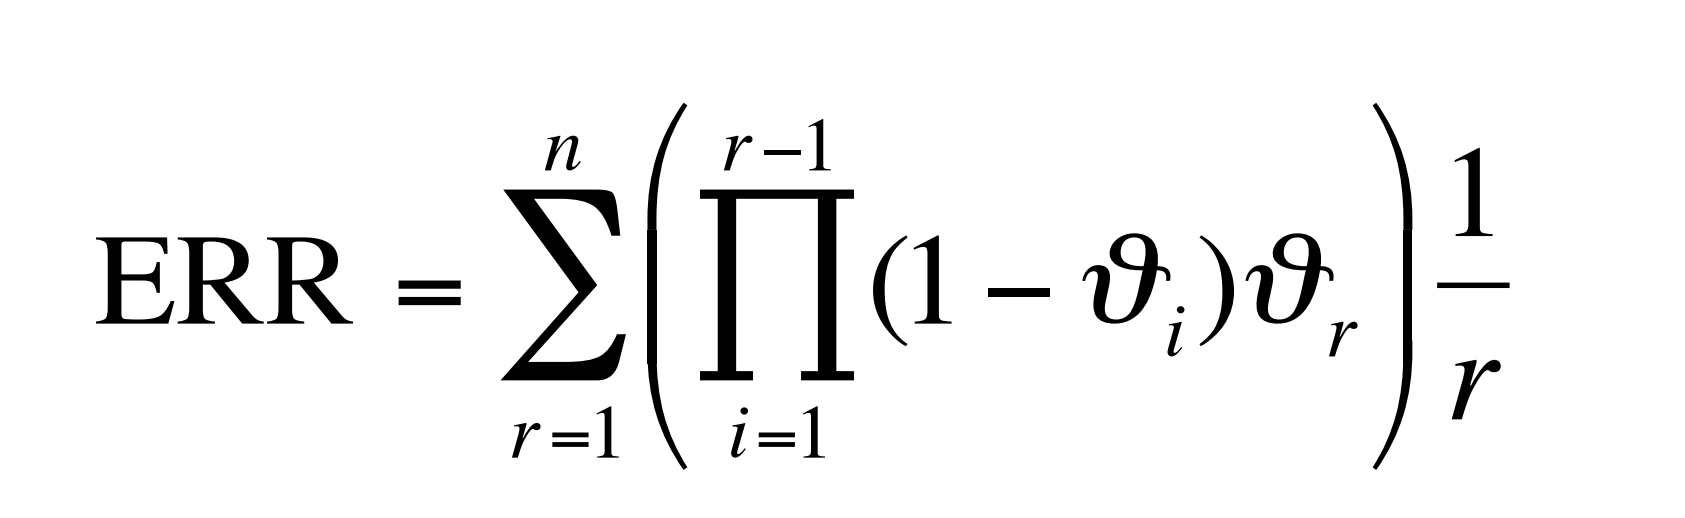

In [ ]:
#delta_ERR = np.zeros((10,3))
#relevance_number = {"min": delta_ERR[:,0], "median": delta_ERR[:,1], "max": delta_ERR[:,2]}

def calculate_ERR(rank_list):
    """ Calculates the ERR for a ranked list of documents.
    Input: 
        rank_list: list of probabilities of stoping in that positon for each position in the rank.
    Output: ERR"""
    ERR = 0
    for r in range(len(rank_list)):
        temp = 1
        for i in range(r):
            temp *= 1-rank_list[i]
        ERR += temp*rank_list[r]/(r+1)
    return ERR

def group_dERRs(rank_pairs):
    """calculate the ERR values for the production and experimental system and groups their deltas into bins.
    Input:
        rank_pairs: a list of lists of list.
    Output: dictionary with the indeces of rank_pairs binned in groups from 0 to 9.
    """
    delta_ERR = {k:[] for k in range(10)}
    
    for i, p in enumerate(rank_pairs):
        
        #Calculate seperate ERRs
        #ERRs hardcoded to r= 3, that is not great implementation but it works.
        #ERR_p = p[0][0] + (1-p[0][0])*p[0][1]/2 + (1-p[0][0])*(1-p[0][1])*p[0][2]/3
        #ERR_e = p[1][0] + (1-p[1][0])*p[1][1]/2 + (1-p[1][0])*(1-p[1][1])*p[1][2]/3
        #calculation not deleted for testing reasons.
        
        ERR_p = calculate_ERR(p[0])
        ERR_e = calculate_ERR(p[1])
        
        #Groups the delta ERRs based on their differences
        d_ERR = ERR_e - ERR_p 
        if d_ERR >= 0.05 and d_ERR <= 0.95:
            #stores the index of the pair
            delta_ERR[int(d_ERR*10)].append(i)
            
    return delta_ERR

rank_pairs = creat_rank_pairs(labels = [0, 1] , n=3)
grouped_dERRs = group_dERRs(rank_pairs)
print(grouped_dERRs)

# Step 3: Implement Team-Draft Interleaving and Probabilistic Interleaving

Implement Team-Draft and Probabilistic Interleaving, with methods that interleave two rankings, and given the users clicks on the interleaved ranking assign credit to the algorithms that produced the rankings.

In [ ]:
def teamdraft_interleaving(A, B):
    """ Given two lists A and B, constructs a new interleaved list newl using team-draft interleaving
         The new list newl consists of three elements. A list source(same size as newl) is also constructed, where "A"
         means that the element of newl is present in list A, "B" in list B and "AB" in both.
    Input:
        list A, list B
    Output:
        list newl, list source
    """
    newl = []
    source = []  
        
    for idx in range(3):
        
        entry_a = A[idx]
        entry_b = B[idx]
        
        if random() < 0.5:
            
            if entry_a not in newl:
                newl.append(entry_a)
                source.append("A")
                
                if entry_b not in newl:
                    newl.append(entry_b)
                    source.append("B")
                    
            else:
                entry_a = A[idx + 1]
                newl.append(entry_a)
                source.append("A")
                    
        else:
            
            if entry_b not in newl:
                newl.append(entry_b)
                source.append("B")
                
                if entry_a not in newl:
                    newl.append(entry_a)
                    source.append("A")
                    
            else:
                entry_b = B[idx + 1]
                newl.append(entry_b)
                source.append("B")
    
        if len(newl) >= 3:
            break

    return newl[:3], source[:3]
    
        
def probabilistic_interleaving(A, B):
    """ Given two lists A and B, constructs a new interleaved list newl using probablistic interleaving
         The new list newl consists of three elements. A list source(same size as newl) is also constructed, where "A"
         means that the element of newl is present in list A, "B" in list B and "AB" in both.
    Input:
        list A, list B
    Output:
        list newl, list source
    """
    
    def assign_probabilities(rank_X, tau = 3):
        """ returns a probability distribution according to the inverse power rank
        Inputs:
            rank_X: np array of the ranked documents
            tau: int, default 3 (authors of original paper)
        Outputs:
            probability distribution of the documents
        """
        inverse_power_rank = 1 / np.power(rank_X, tau)
        normalizing_factor = inverse_power_rank.sum()
        return inverse_power_rank / normalizing_factor
    
    newl = []
    source = []
    
    original_A = copy(A)
    original_B = copy(B)
    
    rank_A = np.arange(len(A)) + 1
    rank_B = np.arange(len(B)) + 1
    
    while len(newl) < 3:

        if random() < 0.5:
            primary_list = A
            primary_original_list = original_A
            rank_primary = rank_A
            secondary_list = B
            secondary_original_list = original_B
            rank_secondary = rank_B
            
            source.append("A")
            
        else:
            primary_list = B
            primary_original_list = original_B
            rank_secondary = rank_B
            secondary_list = A
            secondary_original_list = original_A
            rank_primary = rank_A
            
            source.append("B")
            
        softmax = assign_probabilities(rank_primary)
        cum_prob_distr = softmax.cumsum()
        random_point = random()
        
        # if the lists are small and have huge overlap,
        # one of them might be empty exactly when the new list newl is full
        try:
            doc_index = np.where(random_point < cum_prob_distr)[-1][0]
            doc = primary_list[doc_index]
        except IndexError:
            break
        
        newl.append(doc)
        
        primary_list.remove(doc)
        np.delete(rank_primary, np.where(primary_original_list == doc)[0])
        
        if doc in secondary_list:
            secondary_list.remove(doc)
            np.delete(rank_secondary, np.where(secondary_original_list == doc)[0])
           
    return newl[:3], source[:3]       

# Step 4 Simulate User Clicks

In [ ]:
type_idx = 2
query_idx = 3
click_id_idx = 3
rank_idx = 5

def parseSession(buffer):
    if(len(buffer) == 0):
        return []
    
    query = buffer[0][query_idx]
    ranking = buffer[0][rank_idx:]
    clicks = [0] * len(ranking)
    
    for record in buffer[1:]:
        click_id = record[click_id_idx].replace('\n', '')
        if(click_id in ranking):
            idx = ranking.index(click_id)
            clicks[idx] = 1
    
    return (query, ranking, clicks)

# Returned format:
# list of (query_id, urls, clicks)
def loadData():
    S = []
    with open('YandexRelPredChallenge.txt', 'r') as file:
        buffer = []
        for line in file:
            values = line.split('\t')
            if(values[type_idx] == 'Q'):
                session = parseSession(buffer)
                if(len(session) > 0):
                    S.append(session)
                buffer = []
            buffer.append(values)

        session = parseSession(buffer)
        if(len(session) > 0):
            S.append(session)
    return S

In [ ]:
S = loadData()
print('Total sessions:',len(S))

In [ ]:
class PBM:
    def __init__(self, max_rank, grades, epsilon):
        self.exams = np.random.uniform(0.25, 0.75, max_rank)
        self.attrs = defaultdict(lambda:np.random.uniform(0.25, 0.75))
        self.epsilon = epsilon
        self.max_rank = max_rank
    
    def estimate_attractiveness(self, attrs, exams, max_rank, train_data):
        attrs_new = deepcopy(attrs)
        qu_counter = Counter()

        for query, urls, clicks in train_data:
            for r in range(max_rank):
                a = attrs[(query, urls[r])]
                g = exams[r]
                c = clicks[r]

                qu_counter[(query, urls[r])] += 1
                attrs_new[(query, urls[r])] = c + (1 - c) * ((1 - g) * a)/(1 - g * a)

        for key, value in qu_counter.items():
            attrs_new[key] /=  value

        return attrs_new
        
    def estimate_examination(self, attrs, exams, max_rank, train_data):
        exams_new = deepcopy(exams)

        for query, urls, clicks in train_data:
            for r in range(max_rank):
                a = attrs[(query, urls[r])]
                g = exams[r]
                c = clicks[r]

                exams_new[r] += c + (1 - c) * (g * (1 - a))/(1 - g * a)

        for r in range(max_rank):
            exams_new[r] /= len(train_data)

        return exams_new
    
    def train(self, train_data, max_iterations = 50):
        for i in range(max_iterations):
            new_attrs = self.estimate_attractiveness(self.attrs, self.exams, self.max_rank, train_data)
            new_exams = self.estimate_examination(self.attrs, self.exams, self.max_rank, train_data)
            
            da = 0
            for key,value in self.attrs.items():
                da += self.attrs[key] - new_attrs[key]
            
            dg = 0
            for r in range(self.max_rank):
                dg += self.exams[r] - new_exams[r]
            print(i,'delta attr', da, 'delta exam', dg)
            
            if(da < 0.0001):
                break
                
            self.exams = new_exams
            self.attrs = new_attrs
        
        print('train', self.exams, list(self.attrs.items())[:10])
        
        # Override with examination probabilities from PyClick for now
        self.exams = [0.9952, 0.4708, 0.3321]
        
    def predict_prob(self, ranking):
        prob = [0] * self.max_rank
        for r in range(self.max_rank):
            attr = 1 - self.epsilon if ranking[r] == 1 else self.epsilon
            prob[r] = self.exams[r] * attr
        return prob
        
    def sample_click(self, rank, probabilities):
        return 1 if random() < probabilities[rank] else 0;
        print('sample_click')
        

In [ ]:
#Example
model_PBM = PBM(3,2,0.001)
model_PBM.train(S)
prob = model_PBM.predict_prob([1,1,1])
print(prob)
for _ in range(100):
    print(model_PBM.sample_click(2, prob))

In [ ]:
# Random Click Model
class RCM:
    def __init__(self, max_rank, p):
        self.p = p
        self.max_rank = max_rank
    
    def train(self, train_data):
        print('nothing to train...')
        
    def predict_prob(self, ranking):
        return [self.p] * self.max_rank
        
    def sample_click(self, rank, probabilities):
        return 1 if random() < self.p else 0;
        

In [ ]:
model_RCM = RCM(3,0.5)
model_RCM.train(S)
prob = model_RCM.predict_prob([1,1,1])
print(prob)
for _ in range(10):
    print(model_RCM.sample_click(2, prob))

# Step 5: Simulate Interleaving Experiment
Having implemented the click model, it is time to run the simulated experiment.

For each of interleaving experiment run k simulations for each one of the two click models implemented and measure the proportion p of wins for E. Group these proportions in the respective group the interleaved ranking came from. The larger the k the better, but also the larger the k the longer it takes to run the experiment; so make a reasonable choice.

In [ ]:
def create_document_permuts(rel_dict = {"a": 1, "b": 1, "c": 1, "d": 0, "e": 0, "f": 0}, l = 3):
    """Returns all permutations of documents and all combinations of two lists of permutations.
    Input:
        rel_dict: dictionary mapping keys to relevance.
        l: lengh of the list of permutations.
    Return:
        doc_permuts: all permutations of keys of rel_dict in tuples of lengh l.
        doc_lists: list of lists of combinations of the doc_permuts"""
    
    #create all possible permutations of lengh l
    doc_permuts = list(itertools.permutations(rel_dict.keys(), l)) 
    
    #create all combinations of two lists of doc_permutations 
    doc_lists = [[dp, de] for de in doc_permuts for dp in doc_permuts]
    
    return doc_permuts, doc_lists

#print (create_documents())

In [ ]:
rel_dict = {"a": 1, "b": 1, "c": 1, "d": 0, "e": 0, "f": 0}
doc_permuts, doc_lists = create_document_permuts(rel_dict = rel_dict, l = 3)

k = 100

def oline_test_simulation(interleaving_method, click_model, k, rel_dict, doc_lists):
    wins_E = 0
    wins_P = 0
    ties = 0

    for i in range(k):
        #randomly choses a combination of doc_lists
        doc_idx = randint(0, len(doc_lists)-1)
        E = list(doc_lists[doc_idx][1])
        P = list(doc_lists[doc_idx][0])
        emergency_EP = (E.copy(), P.copy())
        
        #interleaves E and P
        newl, source = interleaving_method(E, P)
    
        #just in case
        if len(newl) != 3:
            print(f"ERROR {i} newl:", newl, "E:", E, "P:", P, "source:", source, "original EP:", emergency_EP)

        #gets the relevances for each document in the list
        relevances = [rel_dict[key] for key in newl]
        
        #simulates the online testing by using a click model
        prob = click_model.predict_prob(relevances)
        
        #counts the clicks that E and P gets
        c = [0]*len(newl)
        click_count_E = 0
        click_count_P = 0
        for j in range(len(newl)):
            c[j] = click_model.sample_click(i, prob) 
            if source[j] == "A":
                click_count_E += c[j]
            else: 
                click_count_P += c[j]
        
        #calculates wins of E and P and ties
        if click_count_E > click_count_P:     
            wins_E +=1
        elif click_count_E < click_count_P:
            wins_P +=1
        else:
            ties += 1
            
    return wins_E, wins_P, ties


interleaving_method = teamdraft_interleaving 
click_model = model
wins_E, wins_P, ties = oline_test_simulation(interleaving_method, click_model, k, rel_dict, doc_lists)  
print(wins_E, wins_P, ties)

interleaving_method = probabilistic_interleaving 
click_model = model
print("probabilistic")
wins_E, wins_P, ties = oline_test_simulation(interleaving_method, click_model, k, rel_dict, doc_lists)  
print(wins_E, wins_P, ties)